In [1]:
from datetime import datetime
from pyspark import SparkContext, HiveContext
from pyspark.sql import SparkSession, SQLContext
import pyspark.sql.functions as funcs
import pandas as pd
from pyspark.sql.functions import row_number,lit
from pyspark.sql.window import Window

In [2]:
spark = (SparkSession.builder.appName("pyspark-test-{}".format(datetime.today()))
        .master("spark://spark-master:7077")      
        .getOrCreate())
sqlContext = SQLContext(spark)

/usr/local/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
data_minio = spark.read.format("delta").load("s3a://warehouse/data_transform.delta", header=True)
data_minio.limit(5).toPandas()

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,tps,data_time,bank_send,bank_receive,proxy_type,datatype,date,year,month,day,hour,minute,second
0,4,2023-05-30 07:20:02,KTB,SCB,NATID,TPS_SWT_LEG1_LEG2_byBANK_andPROXY,2023-05-30,2023,5,30,7,20,2
1,10,2023-05-30 07:24:02,KBNK,GSB,ACCOUNT,TPS_SWT_LEG1_LEG2_byBANK_andPROXY,2023-05-30,2023,5,30,7,24,2
2,70,2023-05-30 10:22:24,SCB,KBNK,ACCOUNT,TPS_SWT_LEG1_LEG2_byBANK_andPROXY,2023-05-30,2023,5,30,10,22,24
3,6,2023-05-30 07:24:02,KBNK,GSB,EWALLET,TPS_SWT_LEG1_LEG2_byBANK_andPROXY,2023-05-30,2023,5,30,7,24,2
4,3,2023-05-30 07:20:02,TMB,SCB,ACCOUNT,TPS_SWT_LEG1_LEG2_byBANK_andPROXY,2023-05-30,2023,5,30,7,20,2


In [4]:
temp = data_minio.select("*")
temp = temp.filter(temp.bank_send == "SCB")
temp = temp.filter(temp.bank_receive == "KBNK")
temp.count()

284169

In [5]:
temp = temp.drop("bank_send","bank_receive","datatype")

In [6]:
data_df = temp.toPandas()

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [7]:
data_df

,tps,data_time,proxy_type,date,year,month,day,hour,minute,second
0,70,2023-05-30 10:22:24,ACCOUNT,2023-05-30,2023,5,30,10,22,24
1,2,2023-05-30 10:22:24,EWALLET,2023-05-30,2023,5,30,10,22,24
2,10,2023-05-30 10:22:24,MSISDN,2023-05-30,2023,5,30,10,22,24
3,6,2023-05-30 10:22:25,BILLERID,2023-05-30,2023,5,30,10,22,25
4,3,2023-05-30 10:22:25,EWALLET,2023-05-30,2023,5,30,10,22,25
...,...,...,...,...,...,...,...,...,...,...
284164,28,2023-05-30 20:14:57,MSISDN,2023-05-30,2023,5,30,20,14,57
284165,72,2023-05-30 20:14:58,ACCOUNT,2023-05-30,2023,5,30,20,14,58
284166,2,2023-05-30 20:14:58,EWALLET,2023-05-30,2023,5,30,20,14,58
284167,21,2023-05-30 20:14:58,MSISDN,2023-05-30,2023,5,30,20,14,58


In [8]:
data_df.drop(['date','year','month','day','hour','minute','second'],axis=1,inplace=True)

In [9]:
KBNK_SCB_A = data_df.loc[data_df['proxy_type'] == 'ACCOUNT'].reset_index()
KBNK_SCB_B = data_df.loc[data_df['proxy_type'] == 'BILLERID'].reset_index()
KBNK_SCB_E = data_df.loc[data_df['proxy_type'] == 'EWALLET'].reset_index()
KBNK_SCB_M = data_df.loc[data_df['proxy_type'] == 'MSISDN'].reset_index()
KBNK_SCB_N = data_df.loc[data_df['proxy_type'] == 'NATID'].reset_index()

In [10]:
split_data = [KBNK_SCB_A,KBNK_SCB_B,KBNK_SCB_E,KBNK_SCB_M,KBNK_SCB_N]
type = ['ACCOUNT', 'BILLERID', 'EWALLET', 'MSISDN', 'NATID']
real = []

full_ts_secs = pd.date_range("2023-05-30 00:00:00", "2023-05-30 23:59:59", freq='S')
full_ts_secs = pd.DataFrame(full_ts_secs)
full_ts_secs.rename(columns={0:'data_time'},inplace=True)

for data in range(len(split_data)):
        temp = split_data[data].copy()
        temp = temp.set_index(['data_time'])
        temp_new = temp.reindex(full_ts_secs['data_time'])
        temp_new.reset_index(inplace=True)
        temp_new['tps'] = temp_new['tps'].fillna(0)
        temp_new['proxy_type'] = temp_new['proxy_type'].fillna(type[data])
        real.append(temp_new)

In [11]:
new_df = pd.concat(real)
new_df.drop(['index'],axis=1,inplace=True)
one_hot = pd.get_dummies(new_df,columns=['proxy_type'])

train_data = one_hot.copy()

train_data['second']=train_data.data_time.dt.second
train_data['minute']=train_data.data_time.dt.minute
train_data['hour']=train_data.data_time.dt.hour
train_data['day'] =train_data.data_time.dt.day
train_data['weekday'] =train_data.data_time.dt.weekday

In [12]:
len(train_data)

432000

In [13]:
train_data.head()

,data_time,tps,proxy_type_ACCOUNT,proxy_type_BILLERID,proxy_type_EWALLET,proxy_type_MSISDN,proxy_type_NATID,second,minute,hour,day,weekday
0,2023-05-30 00:00:00,0.0,1,0,0,0,0,0,0,0,30,1
1,2023-05-30 00:00:01,0.0,1,0,0,0,0,1,0,0,30,1
2,2023-05-30 00:00:02,0.0,1,0,0,0,0,2,0,0,30,1
3,2023-05-30 00:00:03,0.0,1,0,0,0,0,3,0,0,30,1
4,2023-05-30 00:00:04,0.0,1,0,0,0,0,4,0,0,30,1


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pandas.core.common import random_state
from sklearn.linear_model import LinearRegression

In [15]:
temp_1 = train_data.copy()

In [16]:
temp_1

,data_time,tps,proxy_type_ACCOUNT,proxy_type_BILLERID,proxy_type_EWALLET,proxy_type_MSISDN,proxy_type_NATID,second,minute,hour,day,weekday
0,2023-05-30 00:00:00,0.0,1,0,0,0,0,0,0,0,30,1
1,2023-05-30 00:00:01,0.0,1,0,0,0,0,1,0,0,30,1
2,2023-05-30 00:00:02,0.0,1,0,0,0,0,2,0,0,30,1
3,2023-05-30 00:00:03,0.0,1,0,0,0,0,3,0,0,30,1
4,2023-05-30 00:00:04,0.0,1,0,0,0,0,4,0,0,30,1
...,...,...,...,...,...,...,...,...,...,...,...,...
86395,2023-05-30 23:59:55,5.0,0,0,0,0,1,55,59,23,30,1
86396,2023-05-30 23:59:56,1.0,0,0,0,0,1,56,59,23,30,1
86397,2023-05-30 23:59:57,0.0,0,0,0,0,1,57,59,23,30,1
86398,2023-05-30 23:59:58,1.0,0,0,0,0,1,58,59,23,30,1


In [17]:
train = temp_1.loc[temp_1['hour']<21]
test = temp_1.loc[temp_1['hour']>=21]

In [18]:
train_time = train[["data_time"]]
X_train = train.drop(['tps','data_time'],axis=1)
y_train = train[["tps"]]

test_time = test[["data_time"]]
X_test = test.drop(['tps','data_time'],axis=1)
y_test = test[["tps"]]

In [19]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred_test = regressor.predict(X_test)     # predicted value of y_test
y_pred_train = regressor.predict(X_train)   # predicted value of y_train

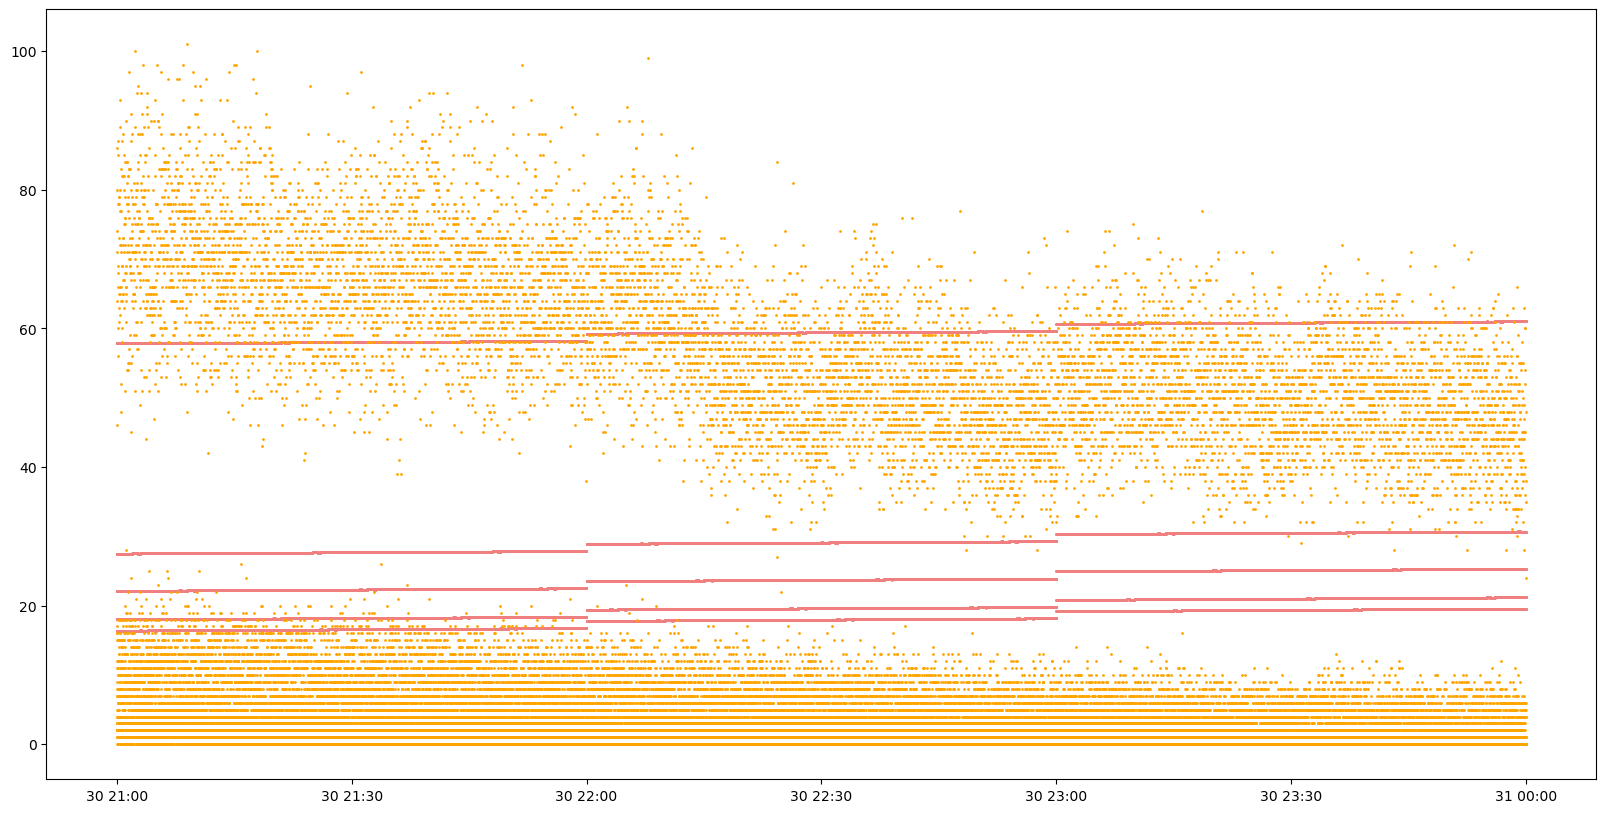

In [20]:
plt.figure(figsize=(20,10))
plt.scatter(test_time["data_time"], y_pred_test, color = 'lightcoral',s=1)
plt.scatter(test_time["data_time"], y_test["tps"], color = 'orange',s=1)
plt.show()

In [21]:
print(f'Coefficient: {regressor.coef_}')
print(f'Intercept: {regressor.intercept_}')

Coefficient: [[ 2.94582593e+01 -6.24580159e+00 -1.19861058e+01 -8.65219577e-01
  -1.03611323e+01 -1.55113634e-04  6.28091577e-03  1.40614964e+00
   0.00000000e+00  0.00000000e+00]]
Intercept: [-1.1440647]


In [22]:
import sklearn.metrics as metrics
mae = metrics.mean_absolute_error(y_test, y_pred_test)
mse = metrics.mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(y_test,y_pred_test)

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 17.619476040851225
MSE: 343.42592571176993
RMSE: 18.53175452329784
R-Squared: 0.31958853115315045
